## cfos_batch_combination_20201125_no_cerebellum
The purpose of this notebook is to do some exploratory data analysis to try to visualize and ultimately understand what is causing the differences in fractional counts between c-Fos brains from different batches.

One of the questions we want to answer is: are the differences between brains from different batches larger than the differences between brains subject to different experimental conditions?

One way to try to answer this is to compare the total and fractional counts coming from large brain divisions between brains in these groups. 

In this notebook I try a set of brain regions suggested by Sam, only focusing on Telencephalon, Diencephalon and Mesencephalon, avoiding Metencephalon which is only the Cerebellum due to mcherry expression being confused with c-Fos expression due to injections.

In [1]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import edt
import seaborn as sns

%matplotlib inline

## Data loading and validation

In [2]:
main_file = '../data/animals_eroded_counts_20201125.csv'
old_main_file = '../data/animals_counts.csv'
pma_segment_props_file = '../data/pma_segment_properties_info'
pma_ontology_json_file = '../data/PMA_ontology.json'
brain_divisions_file = '../data/developmentalregions.xlsx' # contains the telencephalon, mesencephalon, etc regions

In [3]:
with open(pma_ontology_json_file,'r') as infile:
    pma_ontology_dict = json.load(infile)

In [4]:
class Node():
    """ For making the ontology graph"""
    def __init__(self,name):
        self.name = name
        self.parent = None
        self.children = [] # list of Node objects
    def __repr__(self):
        return str(self.name)

In [5]:
class Graph():
    """ The ontology graph """
    def __init__(self):
        self.nodes = {} # map name to Node object
    def make_graph(self,dic):
        name = dic.get('name')
        if name not in self.nodes:
            node = Node(name)
            self.nodes[name] = node
        else:
            node = self.nodes[name]
        
        children = dic.get('children')
        for child in children: # child is a dict
            child_name = child.get('name')
            child_node = Node(child_name)
            child_node.parent = node
            self.nodes[child_name] = child_node
            node.children.append(child_node)
            self.make_graph(child)


In [6]:
# Make a graph containing all brain regions as nodes and parent-child relationships as edges
graph = Graph()
graph.make_graph(pma_ontology_dict)

In [7]:
graph.nodes["root"].children

[Basic cell groups and regions,
 ventricular systems,
 fiber tracts,
 grooves,
 retina]

In [8]:
# Print children of Basic cell groups and regions
graph.nodes["Basic cell groups and regions"].children

[Brain stem, Cerebellum, Cerebrum]

In [9]:
# Read in the new dataframe containing cell counts in each PMA brain region
main_df = pd.read_csv(main_file)
main_df

brain      brain_longname                 condition  \
0     dadult_pc_crus1_1   dadult_pc_crus1_1   vector_control_reversal   
1    dadult_pc_crus1_10  dadult_pc_crus1_10  crusI_bilateral_reversal   
2     dadult_pc_crus1_2   dadult_pc_crus1_2  crusI_bilateral_reversal   
3     dadult_pc_crus1_3   dadult_pc_crus1_3   vector_control_reversal   
4     dadult_pc_crus1_4   dadult_pc_crus1_4   vector_control_reversal   
..                  ...                 ...                       ...   
166               an026               an026          acquisition_day2   
167               an027               an027          acquisition_day2   
168               an028               an028          acquisition_day2   
169               an029               an029          acquisition_day2   
170               an030               an030          acquisition_day2   

                              batch  root  Midbrain  Oculomotor nucleus  \
0    201810_adultacutePC_ymaze_cfos     1      3287                   1   
1    201810_adultacutePC_ymaze_cfos     0         0                   0   
2    201810_adultacutePC_ymaze_cfos     0      1155                   1   
3    201810_adultacutePC_ymaze_cfos     1      3182                   0   
4    201810_adultacutePC_ymaze_cfos     0      2343                   0   
..                              ...   ...       ...                 ...   
166                     202010_cfos     0      5989                   3   
167                     202010_cfos     0      9258                   5   
168                     202010_cfos     9      9192                   0   
169                     202010_cfos     2      2282                   0   
170                     202010_cfos     2      3307                   0   

     Medial terminal nucleus of the accessory optic tract  \
0                                                   20      
1                                                    0      
2                                                    3      
3                                                    8      
4                                                    2      
..                                                 ...      
166                                                 48      
167                                                 45      
168                                                 16      
169                                                 14      
170                                                 20      

     Lateral terminal nucleus of the accessory optic tract  \
0                                                    2       
1                                                    0       
2                                                    7       
3                                                    5       
4                                                   18       
..                                                 ...       
166                                                 20       
167                                                 22       
168                                                  4       
169                                                  6       
170                                                  3       

     Dorsal terminal nucleus of the accessory optic tract  ...  \
0                                                   24     ...   
1                                                    0     ...   
2                                                   16     ...   
3                                                    1     ...   
4                                                   10     ...   
..                                                 ...     ...   
166                                                  0     ...   
167                                                  8     ...   
168                                                 11     ...   
169                                                  0     ...   
170                                 

In [11]:
# Here we want to make a column which contains the sum of counts only in the 
# Telencephalon, Diencephalon, and Mesencephalon. 

# One way to do this is to find all child regions of all regions in these divisions and then 
# sum them up in each row and add a new column with this sum

In [12]:
def get_progeny(dic,parent_structure,progeny_list):
    """ 
    ---PURPOSE---
    Get a list of all progeny of a structure name.
    This is a recursive function which is why progeny_list is an
    argument and is not returned.
    ---INPUT---
    dic                  A dictionary representing the JSON file 
                         which contains the ontology of interest
    parent_structure     The structure
    progeny_list         The list to which this function will 
                         append the progeny structures. 
    """
    name = dic.get('name')
    children = dic.get('children')
    if name == parent_structure:
        for child in children: # child is a dict
            child_name = child.get('name')
            progeny_list.append(child_name)
            get_progeny(child,parent_structure=child_name,progeny_list=progeny_list)
        return
    
    for child in children:
        child_name = child.get('name')
        get_progeny(child,parent_structure=parent_structure,progeny_list=progeny_list)
    return

In [14]:
def get_total_counts(soi,series,debug=False):
    """ Get the total counts in a region
    and all of its descendent regions 
    from a single dataframe series (single brain)
    
    ---INPUT---
    soi    region name of interest
    seires pandas series representing a row (single brain) from the main dataframe
    ---OUTPUT---
    total  the total number of summed
    """
    
    progeny_list=[]
    get_progeny(pma_ontology_dict,parent_structure=soi,progeny_list=progeny_list)
    total=0 #store counts in this list
    # Add the counts for the region itself, if that region is in the dataframe
    try:
        total+=series[soi]
        if debug:
            print(f"{soi} is in dataframe!")
    except:
        if debug:
            print(f"{soi} not in dataframe")
        pass
    for progen in progeny_list:
        try:
            
            count = int(series[progen])
            if debug:
                print(f"{progen} is in dataframe!")
            total+=count    
        except:
            if debug:
                print(f"{progen} not in dataframe")
            pass
    return total

In [13]:
# Provided by Sam
brain_division_dict = {
    'Telencephalon':["Olfactory areas","Isocortex","Cortical subplate","Hippocampal formation","Cerebral nuclei"],
    'Diencephalon':['Interbrain'],
    'Mesencephalon':['Midbrain','Hindbrain'],
#     'Metencephalon':['Cerebellum']
                      }

In [19]:
all_sums_tdm = []
for index,brain_series in main_df.iterrows():
    sum_tdm_this_brain = 0
    for div in brain_division_dict:
        subregions = brain_division_dict[div]
        count_list = [get_total_counts(soi,brain_series) for soi in subregions]
        sum_tdm_this_brain += sum(count_list)
    all_sums_tdm.append(sum_tdm_this_brain)
all_sums_tdm

[61924,
 4,
 37996,
 54398,
 42907,
 45208,
 58490,
 60318,
 53902,
 41598,
 81782,
 56917,
 48626,
 41569,
 45185,
 44739,
 56620,
 8450,
 17079,
 887261,
 346992,
 244155,
 891963,
 532178,
 570345,
 625321,
 561559,
 1190195,
 831686,
 238520,
 497719,
 136352,
 223583,
 107217,
 320760,
 276351,
 295402,
 270946,
 436510,
 680537,
 657675,
 693152,
 756157,
 533366,
 541470,
 347192,
 1010476,
 516270,
 597459,
 216905,
 170066,
 8739,
 8963,
 8897,
 7722,
 11732,
 25011,
 25905,
 24696,
 22278,
 11251,
 18322,
 8540,
 14091,
 15564,
 47359,
 43906,
 50799,
 8244,
 8036,
 11405,
 40211,
 41387,
 37691,
 32847,
 77011,
 520428,
 101294,
 521940,
 577004,
 1028788,
 60420,
 743685,
 680247,
 89022,
 761840,
 57258,
 604766,
 519403,
 593380,
 89236,
 572016,
 637707,
 511988,
 614537,
 526277,
 698831,
 65532,
 563111,
 687970,
 538661,
 543987,
 535644,
 432452,
 528038,
 484860,
 582299,
 428500,
 479821,
 497833,
 496454,
 81492,
 632340,
 650264,
 551992,
 441958,
 511818,
 46739

In [20]:
# Now make a new column holding these sums
main_df['sumcounts_tdm'] = all_sums_tdm

In [21]:
def get_fractional_counts(soi,series,debug=False):
    """ Get the fractional counts in a region
    and all of its descendent regions.
    
    ---INPUT---
    soi    region name of interest
    seires pandas series representing a row (single brain) from the main dataframe
    ---OUTPUT---
    The fractional count of the single soi out of the entire Telencephalon, Diencephalon, Mesencephalon
    """
    
    progeny_list=[]
    get_progeny(pma_ontology_dict,parent_structure=soi,progeny_list=progeny_list)
    total=0 #store counts in this list
    # Add the counts for the region itself, if that region is in the dataframe
    try:
        total+=series[soi]
        if debug:
            print(f"{soi} is in dataframe!")
    except:
        if debug:
            print(f"{soi} not in dataframe")
        pass
    for progen in progeny_list:
        try:
            
            count = int(series[progen])
            if debug:
                print(f"{progen} is in dataframe!")
            total+=count    
        except:
            if debug:
                print(f"{progen} not in dataframe")
            pass
    return total/series['sumcounts_tdm']

In [23]:
test_brain_series = main_df[main_df['batch']=='202010_cfos'].iloc[0]

In [27]:
get_fractional_counts("Cerebral cortex",test_brain_series,debug=False)

0.39812693537423527

OK so now we have a way to get the fractional counts from any region, regardless of whether it is in the dataframe

Now what we want to do is figure out the fractional counts coming from several main brain areas for each brain in a batch and make a boxplot

In [28]:
%%time
# Let's calculate the fractional counts from each of these large brain divisions for the single test brain
total_frac = 0
for division in brain_division_dict:
    subregions = brain_division_dict[division]
    frac_counts = [get_fractional_counts(soi,test_brain_series) for soi in subregions]
    total_frac += sum(frac_counts)
    print(division,sum(frac_counts))
print(total_frac)

Telencephalon 0.5902251537809555
Diencephalon 0.1254500138465799
Mesencephalon 0.28432483237246464
1.0
CPU times: user 17.5 ms, sys: 1.64 ms, total: 19.2 ms
Wall time: 24.9 ms


In [30]:
%%time
# Let's calculate the total counts from each of these large brain divisions for the single test brain
total_counts = 0
for division in brain_division_dict:
    subregions = brain_division_dict[division]
    counts = [get_total_counts(soi,test_brain_series) for soi in subregions]
    total_counts += sum(counts)
    print(division,sum(counts))
sum_df = test_brain_series['sumcounts_tdm']
print(f"Sum of all counts is {total_counts} -- should sum up to {sum_df}")

Telencephalon 70333
Diencephalon 14949
Mesencephalon 33881
Sum of all counts is 119163 -- should sum up to 119163
CPU times: user 16.2 ms, sys: 2.23 ms, total: 18.5 ms
Wall time: 20 ms


# Helper scripts for plots

In [31]:
# helper functions for plots below
def get_counts_dict(batch,condition,count_type):
    """ 
    ---PURPOSE---
    Given a batch and condition, calculate either the total or fractional
    counts in each region for each animal in this batch/condition combo
    in the main dataframe  
    ---INPUT---
    batch          The "experiment" column of the main dataframe
    condition      The "Condition" column of the main dataframe
    count_type     if 'frac' plots using fractional counts. 
                   if 'total' plots using total counts
    ---OUTPUT---
    counts_dict    dictionary[brain][division] = count
    """
    assert count_type in ['frac','total']
    assert batch in main_df['batch'].unique()
    assert condition in main_df['condition'].unique()
    batch_mask = main_df['batch'] == batch
    condition_mask = main_df['condition'] == condition
    comb_mask = np.logical_and(batch_mask,condition_mask)
    batch_condition_df = main_df[comb_mask]
    n_animals = len(batch_condition_df)
    # make a dictionary where keys are Brain names and values are dictionaries mapping brain division
    # to either fractional or total counts
    counts_dict = {}
    for index,brain_series in batch_condition_df.iterrows():
        brain = brain_series['brain']
        counts_dict[brain] = {}
        for division in brain_division_dict:
            subregions = brain_division_dict[division]
            if count_type == 'frac':
                counts = [get_fractional_counts(soi,brain_series) for soi in subregions]
            elif count_type == 'total':
                counts = [get_total_counts(soi,brain_series) for soi in subregions]
            counts_dict[brain][division] = sum(counts)
    return counts_dict


def create_division_df(batch,condition,count_type='frac'):
    """ 
    ---PURPOSE---
    Given a batch and condition create a pandas DataFrame
    containing columns: Brain, Batch, Condition and The major divisions.
    ---INPUT---
    batch          The "experiment" column of the main dataframe
    condition      The "Condition" column of the main dataframe
    count_type     if 'frac' plots using fractional counts. 
                   if 'total' plots using total counts
    """
    counts_dict = get_counts_dict(batch,condition,count_type)

    counts_by_division = []
    for brain in counts_dict:
        division_dict = {'brain':brain}
        for division in counts_dict[brain]:
            division_dict[division] = counts_dict[brain][division]
        counts_by_division.append(division_dict)
    df = pd.DataFrame(counts_by_division)
    df = df.assign(batch=batch,condition=condition)
    return df

# Plotting functions

In [32]:
def make_seaborn_heatmap_batch_condition(batch,condition,count_type='frac',savename=None):
    """ 
    ---PURPOSE---
    Make the cell count or fractional cell count heatmap
    for all animals in a single batch and single condition 
    ---INPUT---
    batch          The "experiment" column of the main dataframe
    condition      The "Condition" column of the main dataframe
    count_type     if 'frac' plots using fractional counts. 
                   if 'total' plots using total counts
    savename       if provided, will save the figure using this filename
    ---OUTPUT---
    ax             returns a matplotlib axis object
    """
    counts_dict = get_counts_dict(batch=batch,
                                 condition=condition,
                                 count_type=count_type)
    # now make a heatmap of counts or fractional counts for each animal in the dataframe. 
    frac_counts_ravelled = []

    for brain in counts_dict:
        for division in counts_dict[brain]:
            entry_dict = {'Brain':brain,'Division':division,'Count':counts_dict[brain][division]}
            frac_counts_ravelled.append(entry_dict)
    df_ravelled = pd.DataFrame(frac_counts_ravelled)
    df_pivot = df_ravelled.pivot("Brain", "Division", "Count")
    df_pivot = df_pivot[list(brain_division_dict.keys())]
    f, ax = plt.subplots(figsize=(9, 6))
    if count_type == 'frac':
        title = f"Fractional counts by brain division in \nbatch={batch}\ncondition={condition}"
        fmt = '.2f'
    elif count_type == 'total':
        title = f"Total counts by brain division in \nbatch={batch}\ncondition={condition}"
        fmt = 'd'
    sns.set(font_scale=1.0)
    sns.heatmap(df_pivot, annot=True, fmt=fmt, linewidths=.5, ax=ax)
    ax.set_title(title,fontsize=14)
    ax.set_ylim(0, len(counts_dict))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor",fontsize=14)
    plt.setp(ax.get_yticklabels(), fontsize=14)
    ax.set_xlabel('Division', fontsize = 20) # X label
    ax.set_ylabel('Brain', fontsize = 20) # Y label

    if savename:
        plt.savefig(savename)


In [98]:
legend_fontsize=12

def make_stripplot_fixed_batch(batch,condition_list,count_type='frac',savename=None):
    """ 
    ---PURPOSE---
    Given a batch and list of conditions make a stripplot
    comparing either fractional or total counts in different conditions
    at fixed batch 
    ---INPUT---
    batch          The "experiment" column of the main dataframe
    condition      The "Condition" column of the main dataframe
    count_type     if 'frac' plots using fractional counts. 
                   if 'total' plots using total counts
    savename       if provided, will save the figure using this filename
    ---OUTPUT---
    ax             returns a matplotlib axis object
    """
    
    df_list = []
    for condition in condition_list:
        df_by_division = create_division_df(batch=batch,
                                            condition=condition,
                                            count_type=count_type)
        df_list.append(df_by_division)
    cdf = pd.concat(df_list)   

    cdf.drop(['brain','batch'],axis=1,inplace=True)
    mdf = pd.melt(cdf, id_vars=['condition'], var_name=['Brain division'])
    if count_type == 'frac':
        value_label = 'fraction of counts'
        title = f"Fraction of counts by brain division at fixed batch={batch}"
    elif count_type == 'total':
        value_label = 'total counts'
        title = f"Total counts by brain division at fixed batch={batch}"
    mdf.rename(columns={'value':value_label},inplace=True)
    
    sns.set_theme(style="whitegrid",context="notebook")
    sns.despine(bottom=True, left=True)
    ax=sns.stripplot(y=value_label, x='Brain division', 
                       data=mdf, 
                       jitter=True,
                       dodge=True,
                       marker='o', 
                       alpha=0.4,
                       s=8,
                       hue='condition')

    ax.set_title(title,fontsize=14)
    _=plt.setp(ax.get_xticklabels(), rotation=75, ha="right",
             rotation_mode="anchor",fontsize=14)
    _=plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.set_ylabel(value_label, fontsize = 20) # X label
    ax.set_xlabel('Brain Division', fontsize = 20) # Y label
    
    # Improve the legend 
    handles, labels = ax.get_legend_handles_labels()
    counts_df = cdf.groupby('condition')['condition'].count()
    numbers_in_samp_dict = {condition:counts_df[condition] for condition in condition_list}
    ax.legend(handles[0:len(condition_list)], 
              [x + f" (N={numbers_in_samp_dict[x]})" for x in labels[0:len(condition_list)]],
              title="Condition",
          handletextpad=0, columnspacing=1,
          loc="upper right", ncol=1, frameon=True,fontsize=legend_fontsize,
             bbox_to_anchor=(1.75, 1))
    if savename:
        plt.savefig(savename)

def make_pointplot_fixed_batch(batch,condition_list,count_type='frac',savename=None):
    """ 
    ---PURPOSE---
    Given a batch and list of conditions make a pointplot
    comparing either fractional or total counts in different conditions
    at fixed batch 
    ---INPUT---
    batch          The "batch" column of the main dataframe
    condition      The "Condition" column of the main dataframe
    count_type     if 'frac' plots using fractional counts. 
                   if 'total' plots using total counts
    savename       if provided, will save the figure using this filename
    ---OUTPUT---
    ax             returns a matplotlib axis object
    """
    
    df_list = []
    for condition in condition_list:
        df_by_division = create_division_df(batch=batch,
                                            condition=condition,
                                            count_type=count_type)
        df_list.append(df_by_division)
    cdf = pd.concat(df_list)   


    cdf.drop(['brain','batch'],axis=1,inplace=True)
    mdf = pd.melt(cdf, id_vars=['condition'], var_name=['Brain division'])
    if count_type == 'frac':
        value_label = 'fraction of counts'
        title = f"Fraction of counts by brain division at fixed batch={batch}"
    elif count_type == 'total':
        value_label = 'total counts'
        title = f"Total counts by brain division at fixed batch={batch}"
    mdf.rename(columns={'value':value_label},inplace=True)
    
    sns.set_theme(style="whitegrid",context="notebook")
    sns.despine(bottom=True, left=True)

    # means +/- std
    ax=sns.pointplot(x="Brain division", y=value_label,
                      data=mdf,
                      dodge=0.5,
                      join=False,
                      palette="bright",
                      markers="d",
                      scale=1.,
                      ci="sd",
                      hue="condition")
    ax.set_title(title,fontsize=14)
    _=plt.setp(ax.get_xticklabels(), rotation=75, ha="right",
             rotation_mode="anchor",fontsize=14)
    _=plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.set_ylabel(value_label, fontsize = 20) # X label
    ax.set_xlabel('Brain Division', fontsize = 20) # Y label
    
    # Improve the legend 
    handles, labels = ax.get_legend_handles_labels()
    counts_df = cdf.groupby('condition')['condition'].count()
    numbers_in_samp_dict = {condition:counts_df[condition] for condition in condition_list}
    ax.legend(handles[0:len(condition_list)], 
              [x + f" (N={numbers_in_samp_dict[x]})" for x in labels[0:len(condition_list)]],
              title="Condition",
          handletextpad=0, columnspacing=1,
          loc="upper right", ncol=1, frameon=True,
             fontsize=legend_fontsize,
             bbox_to_anchor=(1.75, 1))
    if savename:
        plt.savefig(savename)
    
def make_stripplot_fixed_condition(batch_list,condition,count_type='frac'):
    """ Given a list of batches and a condition make a stripplot
    comparing either fractional or total counts in different batches
    at fixed condition """
    
    df_list = []
    for batch in batch_list:
        df_by_division = create_division_df(batch=batch,
                                            condition=condition,
                                            count_type=count_type)
        df_list.append(df_by_division)
    cdf = pd.concat(df_list)   

    cdf.drop(['brain','condition'],axis=1,inplace=True)
    mdf = pd.melt(cdf, id_vars=['batch'], var_name=['Brain division'])
    if count_type == 'frac':
        value_label = 'fraction of counts'
        title = f"Fraction of counts by brain division at fixed condition={condition}"
    elif count_type == 'total':
        value_label = 'total counts'
        title = f"Total counts by brain division at fixed condition={condition}"
    mdf.rename(columns={'value':value_label},inplace=True)
    
    # Show the observations as scatter plots
    sns.set_theme(style="whitegrid",context="notebook")
    sns.despine(bottom=True, left=True)
    ax=sns.stripplot(y=value_label, x='Brain division', 
                       data=mdf, 
                       jitter=True,
                       dodge=True,
                       marker='o', 
                       alpha=0.4,
                       s=8,
                       hue='batch')

    ax.set_title(title,fontsize=14)
    _=plt.setp(ax.get_xticklabels(), rotation=75, ha="right",
             rotation_mode="anchor",fontsize=14)
    _=plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.set_ylabel(value_label, fontsize = 20) # X label
    ax.set_xlabel('Brain Division', fontsize = 20) # Y label
    
    
    # Improve the legend 
    counts_df = cdf.groupby('batch')['batch'].count()
    numbers_in_samp_dict = {batch:counts_df[batch] for batch in batch_list}
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[0:len(batch_list)], 
              [x + f" (N={numbers_in_samp_dict[x]})" for x in labels[0:len(batch_list)]],
              title="Batch",
          handletextpad=0, columnspacing=1,
          loc="upper right", ncol=1, frameon=True,
             fontsize=legend_fontsize,
             bbox_to_anchor=(1.75, 1))
    # plt.savefig('../cfos_fraccount_fixed_condition_prelim.png')

def make_pointplot_fixed_condition(batch_list,condition,count_type='frac'):
    """ Given a list of batches and a condition make a pointplot
    comparing either fractional or total counts in different batches
    at fixed condition """
    
    df_list = []
    for batch in batch_list:
        df_by_division = create_division_df(batch=batch,
                                            condition=condition,
                                            count_type=count_type)
        df_list.append(df_by_division)
    cdf = pd.concat(df_list)   

    cdf.drop(['brain','condition'],axis=1,inplace=True)
    mdf = pd.melt(cdf, id_vars=['batch'], var_name=['Brain division'])
    if count_type == 'frac':
        value_label = 'fraction of counts'
        title = f"Fraction of counts by brain division at fixed condition={condition}"
    elif count_type == 'total':
        value_label = 'total counts'
        title = f"Total counts by brain division at fixed condition={condition}"
    mdf.rename(columns={'value':value_label},inplace=True)
    
    # Show the observations as scatter plots
    sns.set_theme(style="whitegrid",context="notebook")
    sns.despine(bottom=True, left=True)

    # Show the conditional means
    ax=sns.pointplot(x="Brain division", y=value_label,
                      hue="batch",
                      data=mdf,
                      dodge=0.1,
                      join=False,
                      palette="bright",
                      markers="d",
                      scale=1.0,
                      ci="sd")
    ax.set_title(title,fontsize=14)
    _=plt.setp(ax.get_xticklabels(), rotation=75, ha="right",
             rotation_mode="anchor",fontsize=14)
    _=plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.set_ylabel(value_label, fontsize = 20) # X label
    ax.set_xlabel('Brain Division', fontsize = 20) # Y label
    
    
    # Improve the legend 
    counts_df = cdf.groupby('batch')['batch'].count()
    numbers_in_samp_dict = {batch:counts_df[batch] for batch in batch_list}
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[0:len(batch_list)], 
              [x + f" (N={numbers_in_samp_dict[x]})" for x in labels[0:len(batch_list)]],
              title="Batch",
          handletextpad=0, columnspacing=1,
          loc="upper right", ncol=1, frameon=True,
             fontsize=legend_fontsize,
             bbox_to_anchor=(1.75, 1))

# Plots

# Heatmaps

## Batch = 201810_adultacutePC_ymaze_cfos

### total counts

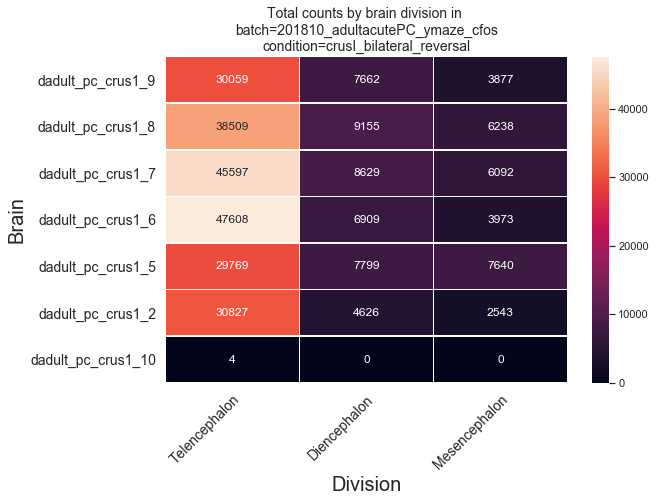

In [99]:
make_seaborn_heatmap_batch_condition(batch='201810_adultacutePC_ymaze_cfos',
                                     condition='crusI_bilateral_reversal',
                                     count_type='total',
                                     savename=None)

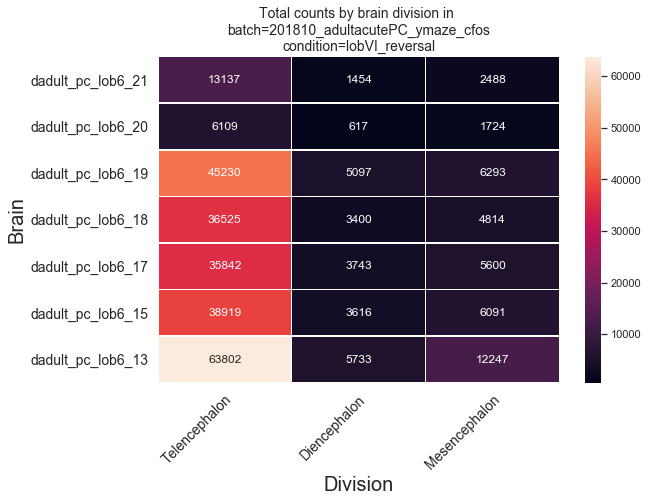

In [100]:
make_seaborn_heatmap_batch_condition(batch='201810_adultacutePC_ymaze_cfos',
                                     condition='lobVI_reversal',
                                     count_type='total',
                                     savename=None)

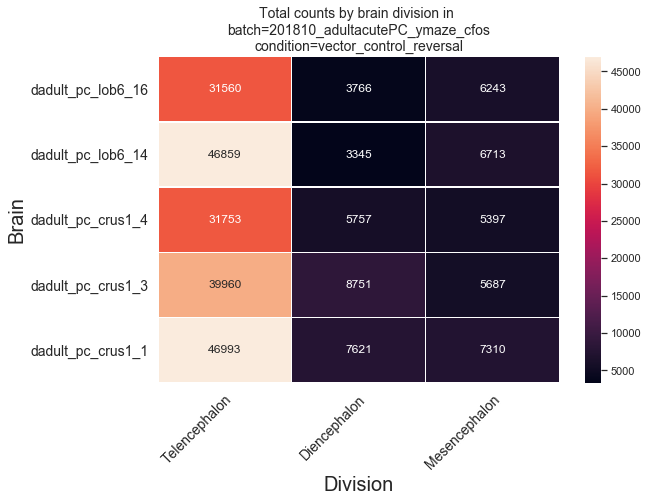

In [37]:
make_seaborn_heatmap_batch_condition(batch='201810_adultacutePC_ymaze_cfos',
                                     condition='vector_control_reversal',
                                     count_type='total',
                                     savename=None)

## fractional counts

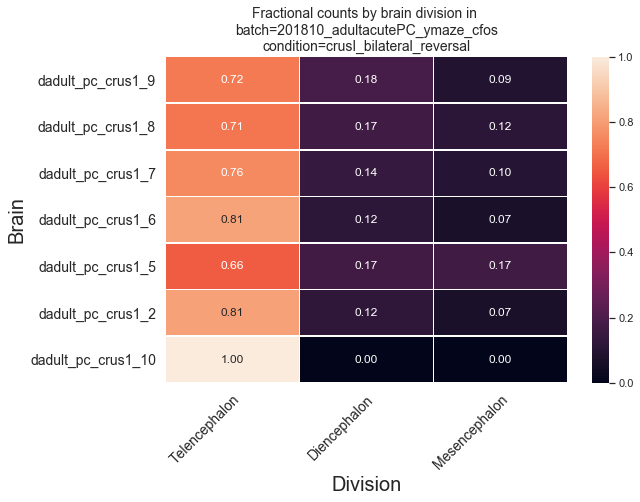

In [38]:
make_seaborn_heatmap_batch_condition(batch='201810_adultacutePC_ymaze_cfos',
                                     condition='crusI_bilateral_reversal',
                                     count_type='frac',
                                     savename=None)

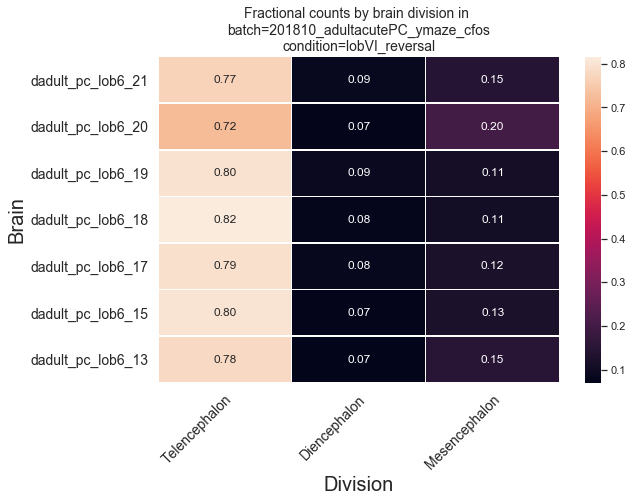

In [39]:
make_seaborn_heatmap_batch_condition(batch='201810_adultacutePC_ymaze_cfos',
                                     condition='lobVI_reversal',
                                     count_type='frac',
                                     savename=None)

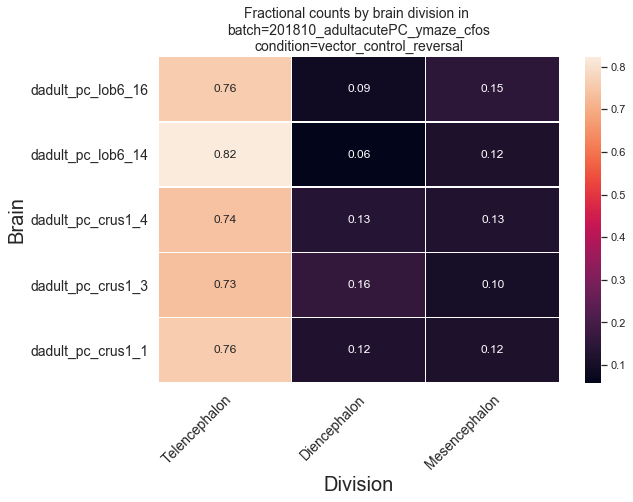

In [41]:
make_seaborn_heatmap_batch_condition(batch='201810_adultacutePC_ymaze_cfos',
                                     condition='vector_control_reversal',
                                     count_type='frac',
                                     savename=None)

## Batch = 201904_ymaze_cfos

## Total counts

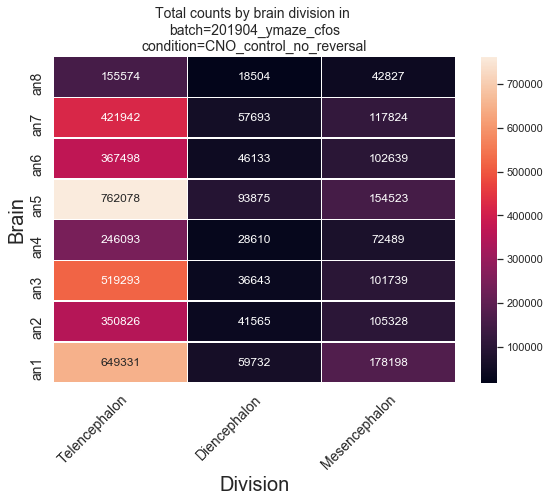

In [42]:
make_seaborn_heatmap_batch_condition(batch='201904_ymaze_cfos',
                                     condition='CNO_control_no_reversal',
                                     count_type='total',
                                     savename=None)

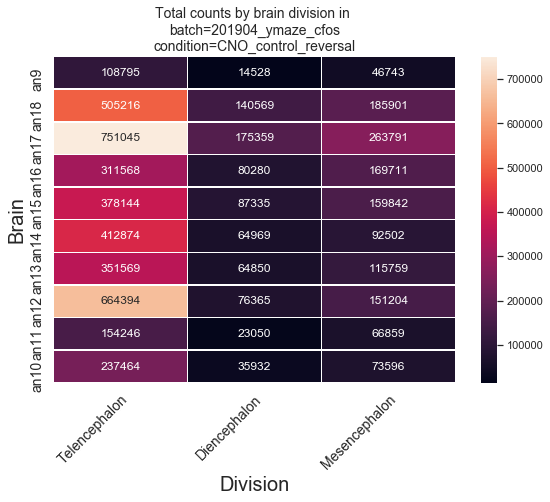

In [43]:
make_seaborn_heatmap_batch_condition(batch='201904_ymaze_cfos',
                                     condition='CNO_control_reversal',
                                     count_type='total',
                                     savename=None)

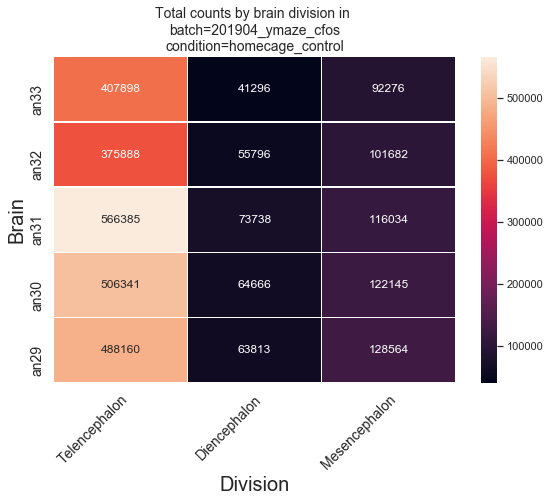

In [44]:
make_seaborn_heatmap_batch_condition(batch='201904_ymaze_cfos',
                                     condition='homecage_control',
                                     count_type='total',
                                     savename=None)

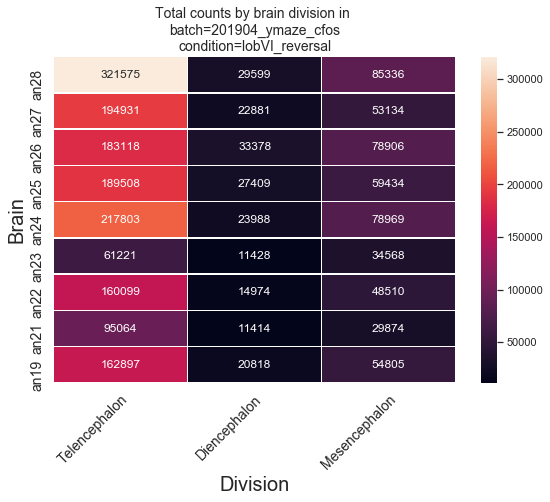

In [45]:
make_seaborn_heatmap_batch_condition(batch='201904_ymaze_cfos',
                                     condition='lobVI_reversal',
                                     count_type='total',
                                     savename=None)

## Fractional counts

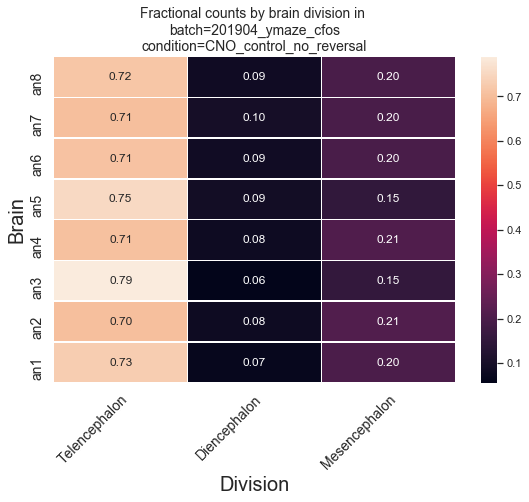

In [46]:
make_seaborn_heatmap_batch_condition(batch='201904_ymaze_cfos',
                                     condition='CNO_control_no_reversal',
                                     count_type='frac',
                                     savename=None)

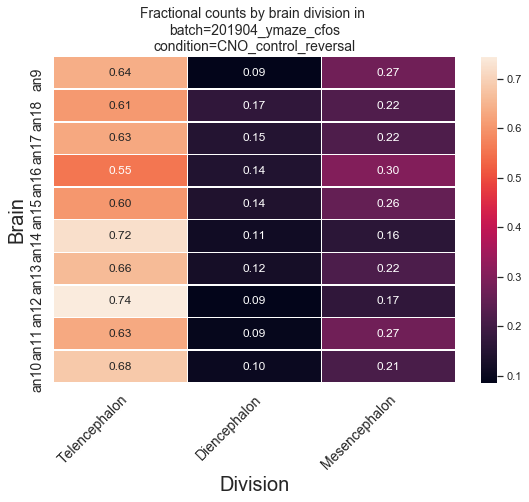

In [47]:
make_seaborn_heatmap_batch_condition(batch='201904_ymaze_cfos',
                                     condition='CNO_control_reversal',
                                     count_type='frac',
                                     savename=None)

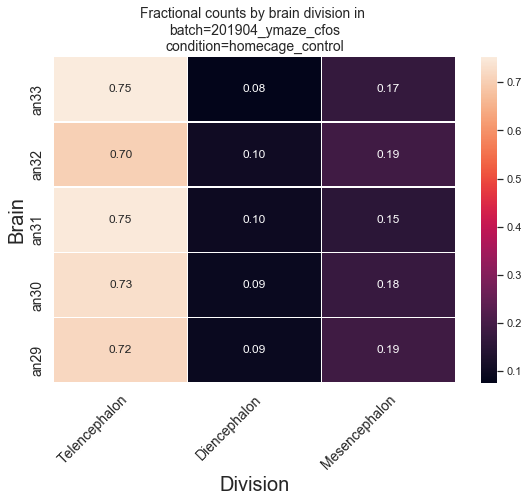

In [48]:
make_seaborn_heatmap_batch_condition(batch='201904_ymaze_cfos',
                                     condition='homecage_control',
                                     count_type='frac',
                                     savename=None)

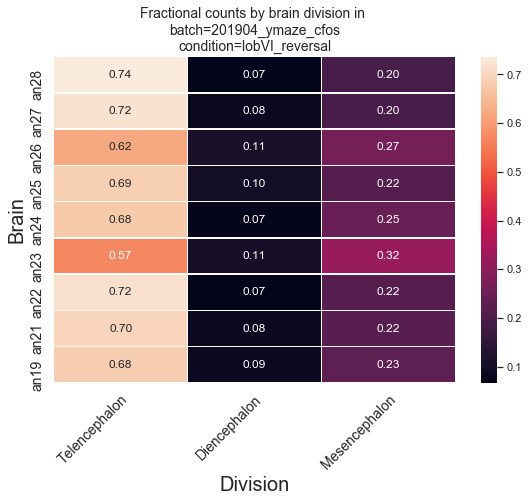

In [49]:
make_seaborn_heatmap_batch_condition(batch='201904_ymaze_cfos',
                                     condition='lobVI_reversal',
                                     count_type='frac',
                                     savename=None)

## Batch = 201908_tpham_ymaze_cfos


### total counts

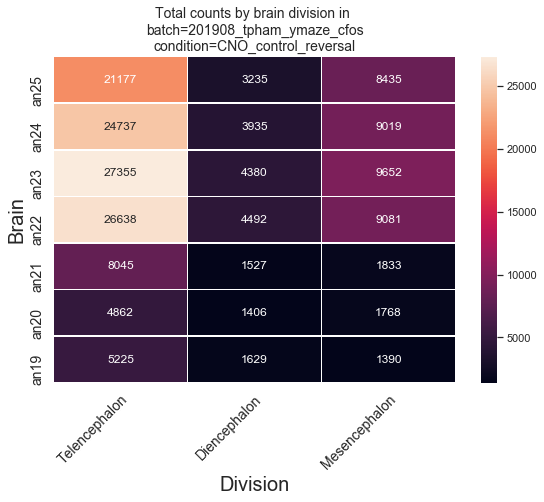

In [50]:
make_seaborn_heatmap_batch_condition(batch='201908_tpham_ymaze_cfos',
                                     condition='CNO_control_reversal',
                                     count_type='total',
                                     savename=None)

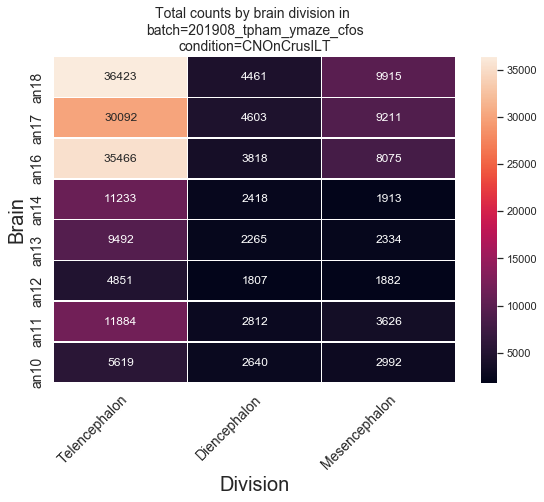

In [51]:
make_seaborn_heatmap_batch_condition(batch='201908_tpham_ymaze_cfos',
                                     condition='CNOnCrusILT',
                                     count_type='total',
                                     savename=None)

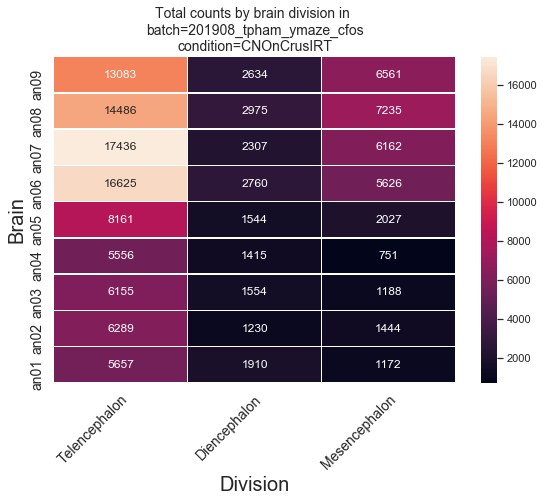

In [52]:
make_seaborn_heatmap_batch_condition(batch='201908_tpham_ymaze_cfos',
                                     condition='CNOnCrusIRT',
                                     count_type='total',
                                     savename=None)

### fractional counts

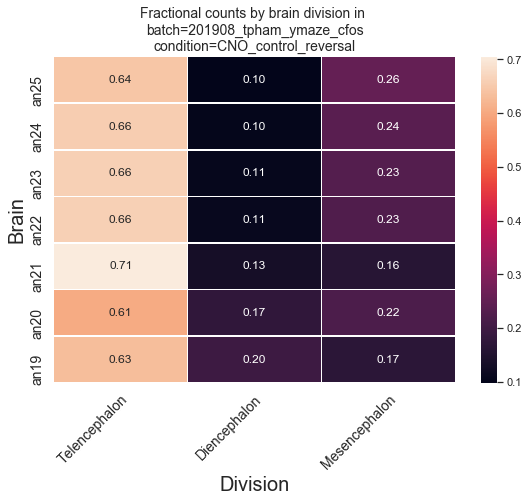

In [53]:
make_seaborn_heatmap_batch_condition(batch='201908_tpham_ymaze_cfos',
                                     condition='CNO_control_reversal',
                                     count_type='frac',
                                     savename=None)

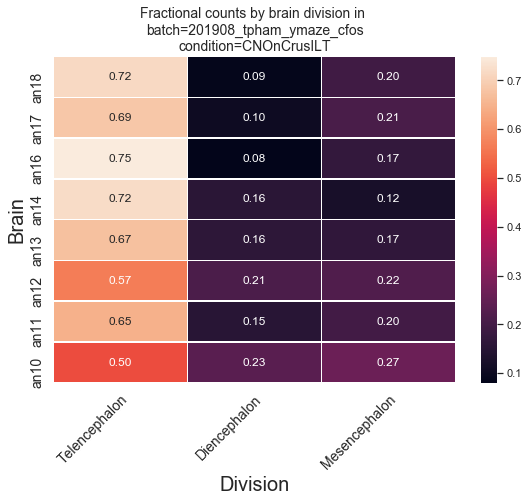

In [54]:
make_seaborn_heatmap_batch_condition(batch='201908_tpham_ymaze_cfos',
                                     condition='CNOnCrusILT',
                                     count_type='frac',
                                     savename=None)

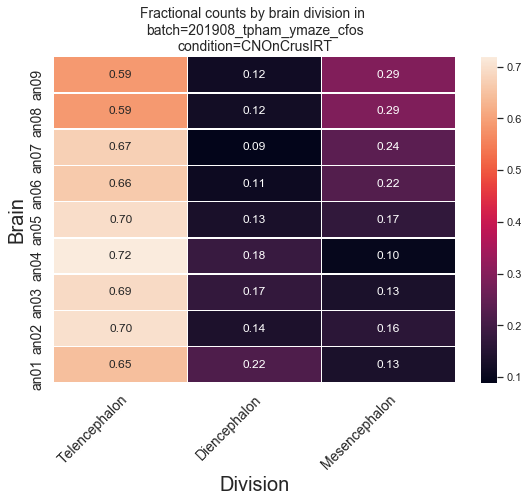

In [55]:
make_seaborn_heatmap_batch_condition(batch='201908_tpham_ymaze_cfos',
                                     condition='CNOnCrusIRT',
                                     count_type='frac',
                                     savename=None)

## Batch = 202002_cfos

### total counts

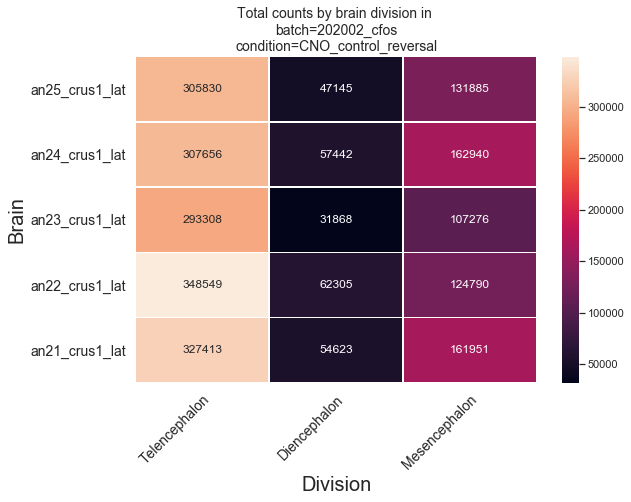

In [56]:
make_seaborn_heatmap_batch_condition(batch='202002_cfos',
                                     condition='CNO_control_reversal',
                                     count_type='total',
                                     savename=None)

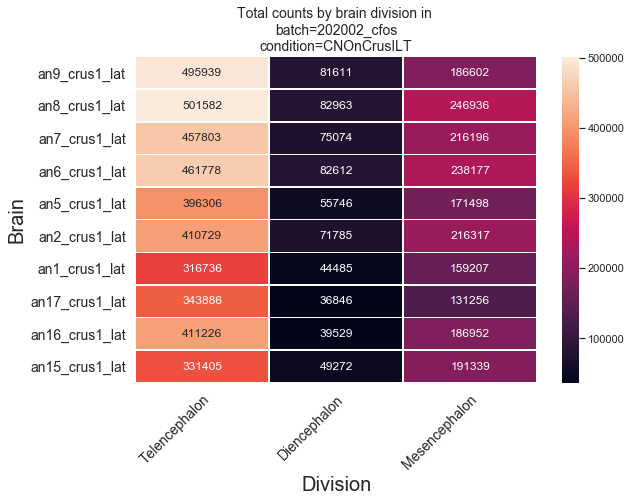

In [57]:
make_seaborn_heatmap_batch_condition(batch='202002_cfos',
                                     condition='CNOnCrusILT',
                                     count_type='total',
                                     savename=None)

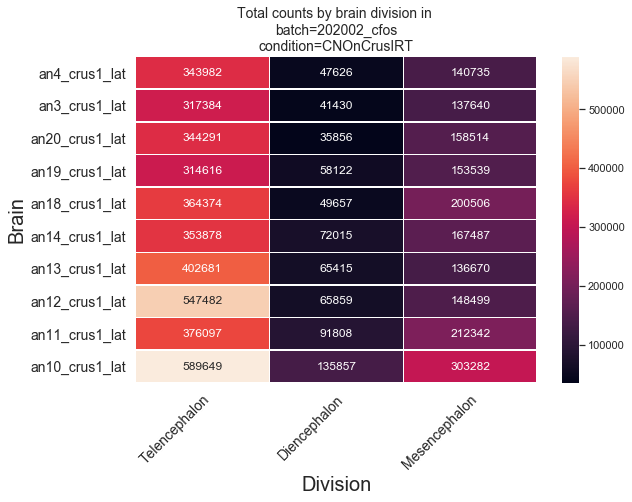

In [58]:
make_seaborn_heatmap_batch_condition(batch='202002_cfos',
                                     condition='CNOnCrusIRT',
                                     count_type='total',
                                     savename=None)

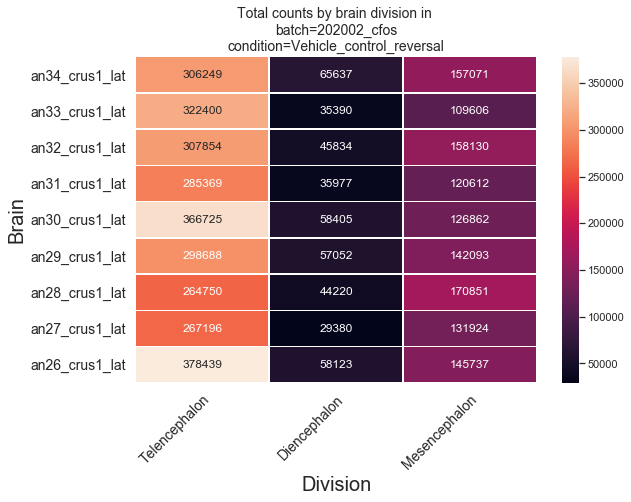

In [59]:
make_seaborn_heatmap_batch_condition(batch='202002_cfos',
                                     condition='Vehicle_control_reversal',
                                     count_type='total',
                                     savename=None)

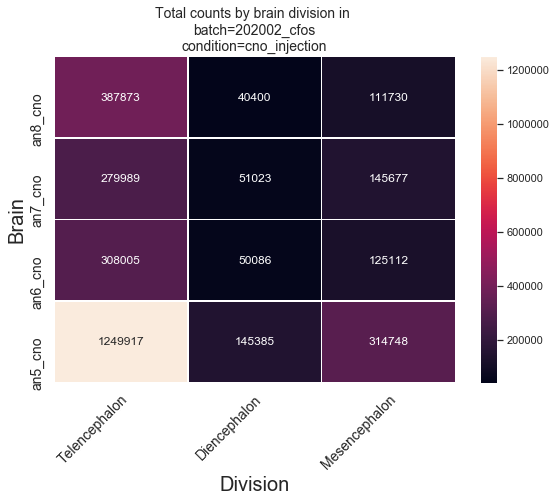

In [60]:
make_seaborn_heatmap_batch_condition(batch='202002_cfos',
                                     condition='cno_injection',
                                     count_type='total',
                                     savename=None)

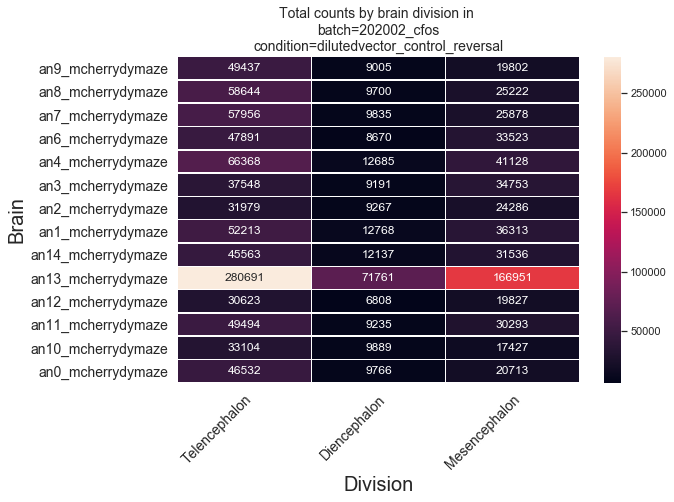

In [61]:
make_seaborn_heatmap_batch_condition(batch='202002_cfos',
                                     condition='dilutedvector_control_reversal',
                                     count_type='total',
                                     savename=None)

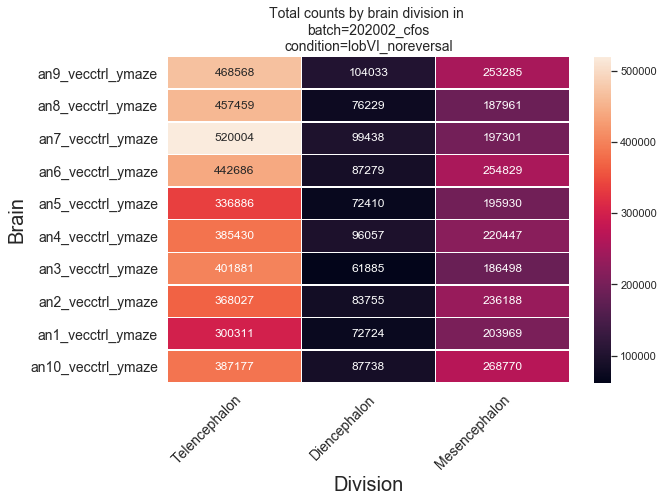

In [62]:
make_seaborn_heatmap_batch_condition(batch='202002_cfos',
                                     condition='lobVI_noreversal',
                                     count_type='total',
                                     savename=None)

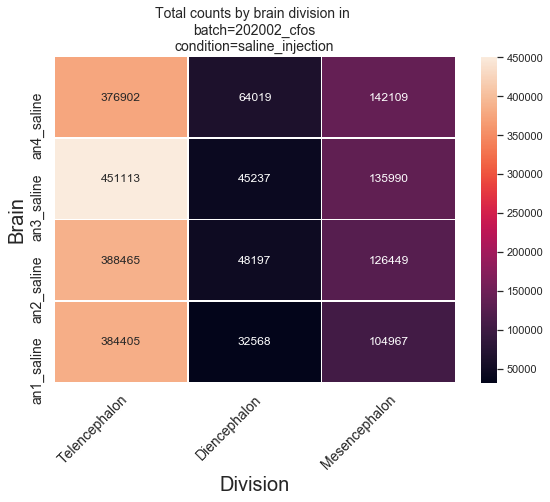

In [63]:
make_seaborn_heatmap_batch_condition(batch='202002_cfos',
                                     condition='saline_injection',
                                     count_type='total',
                                     savename=None)

### fractional counts

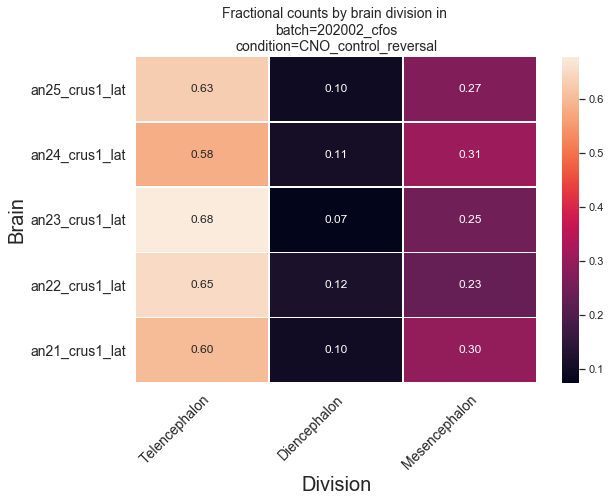

In [64]:
make_seaborn_heatmap_batch_condition(batch='202002_cfos',
                                     condition='CNO_control_reversal',
                                     count_type='frac',
                                     savename=None)

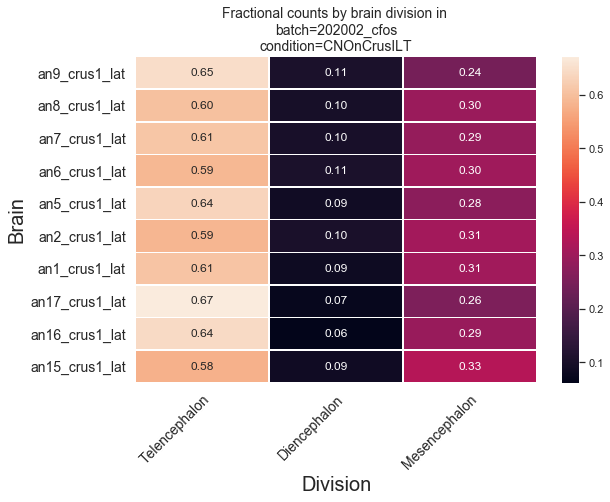

In [65]:
make_seaborn_heatmap_batch_condition(batch='202002_cfos',
                                     condition='CNOnCrusILT',
                                     count_type='frac',
                                     savename=None)

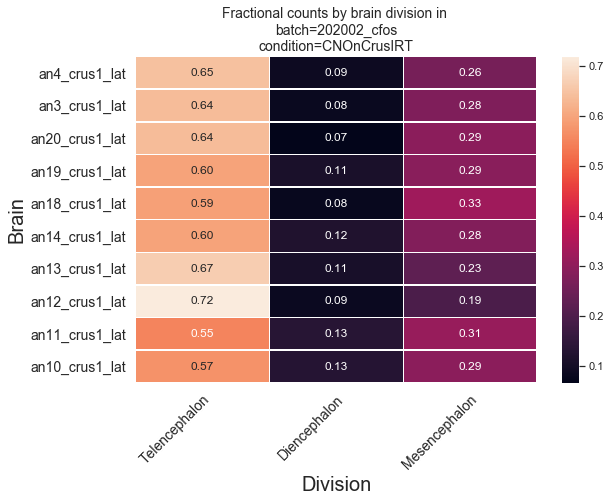

In [66]:
make_seaborn_heatmap_batch_condition(batch='202002_cfos',
                                     condition='CNOnCrusIRT',
                                     count_type='frac',
                                     savename=None)

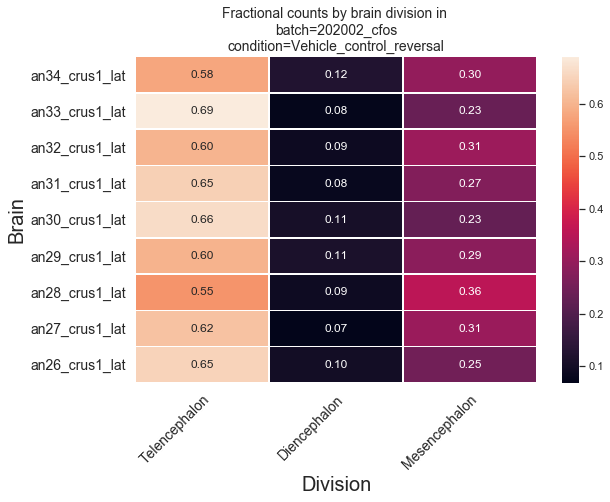

In [67]:
make_seaborn_heatmap_batch_condition(batch='202002_cfos',
                                     condition='Vehicle_control_reversal',
                                     count_type='frac',
                                     savename=None)

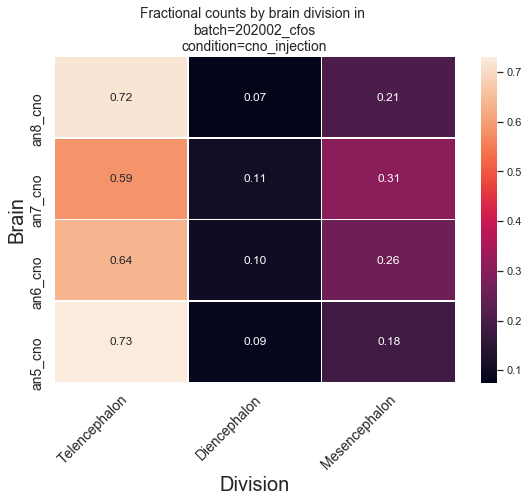

In [68]:
make_seaborn_heatmap_batch_condition(batch='202002_cfos',
                                     condition='cno_injection',
                                     count_type='frac',
                                     savename=None)

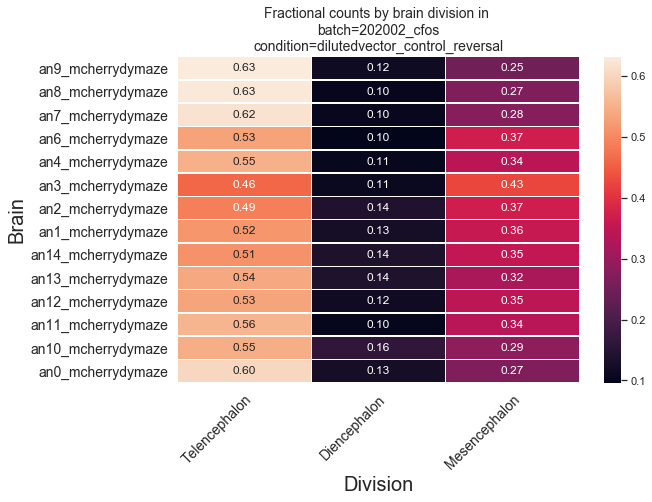

In [69]:
make_seaborn_heatmap_batch_condition(batch='202002_cfos',
                                     condition='dilutedvector_control_reversal',
                                     count_type='frac',
                                     savename=None)

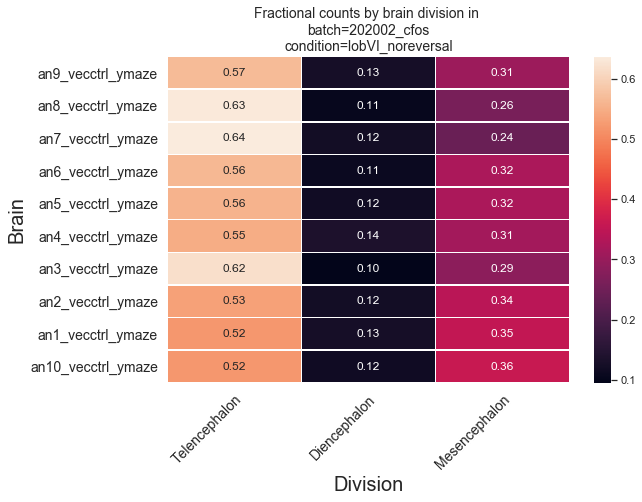

In [70]:
make_seaborn_heatmap_batch_condition(batch='202002_cfos',
                                     condition='lobVI_noreversal',
                                     count_type='frac',
                                     savename=None)

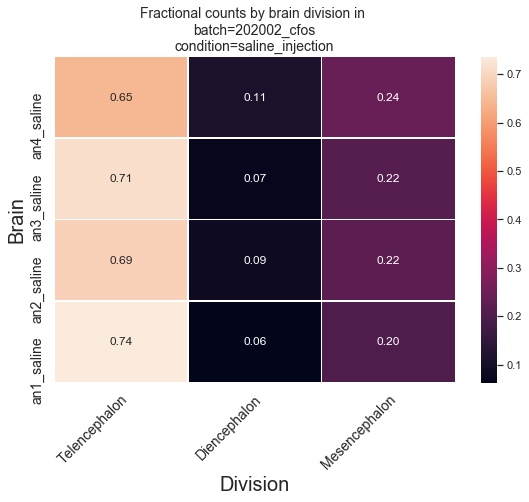

In [71]:
make_seaborn_heatmap_batch_condition(batch='202002_cfos',
                                     condition='saline_injection',
                                     count_type='frac',
                                     savename=None)

## Batch = 202010_cfos

### total counts

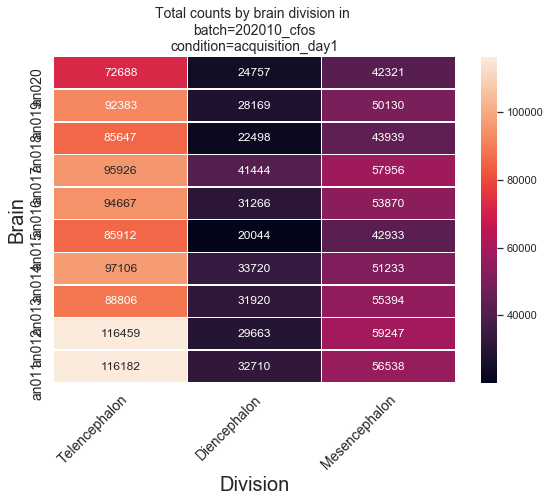

In [72]:
make_seaborn_heatmap_batch_condition(batch='202010_cfos',
                                     condition='acquisition_day1',
                                     count_type='total',
                                     savename=None)

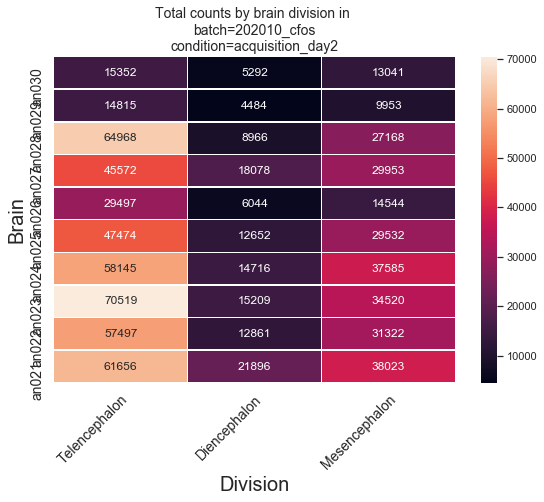

In [73]:
make_seaborn_heatmap_batch_condition(batch='202010_cfos',
                                     condition='acquisition_day2',
                                     count_type='total',
                                     savename=None)

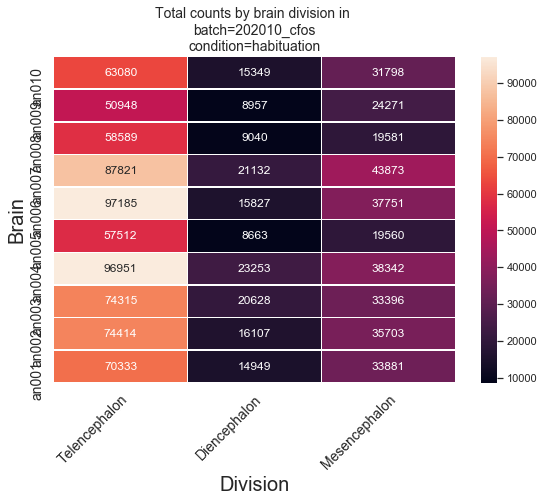

In [74]:
make_seaborn_heatmap_batch_condition(batch='202010_cfos',
                                     condition='habituation',
                                     count_type='total',
                                     savename=None)

### fractional counts

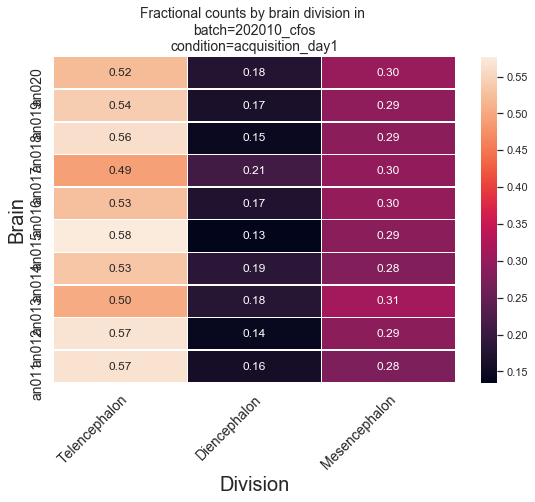

In [75]:
make_seaborn_heatmap_batch_condition(batch='202010_cfos',
                                     condition='acquisition_day1',
                                     count_type='frac',
                                     savename=None)

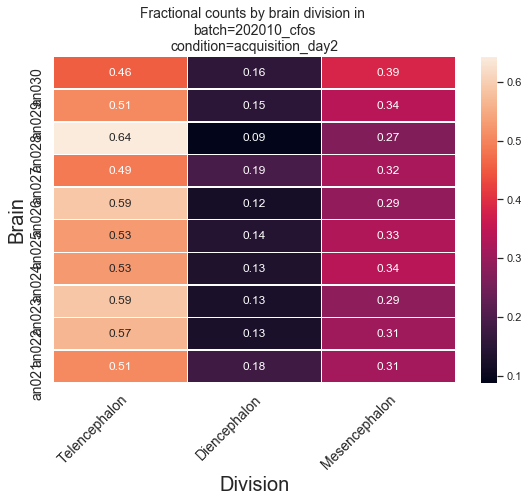

In [76]:
make_seaborn_heatmap_batch_condition(batch='202010_cfos',
                                     condition='acquisition_day2',
                                     count_type='frac',
                                     savename=None)

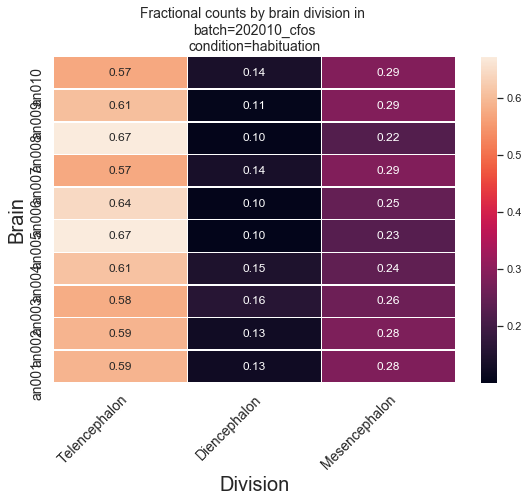

In [77]:
make_seaborn_heatmap_batch_condition(batch='202010_cfos',
                                     condition='habituation',
                                     count_type='frac',
                                     savename=None)

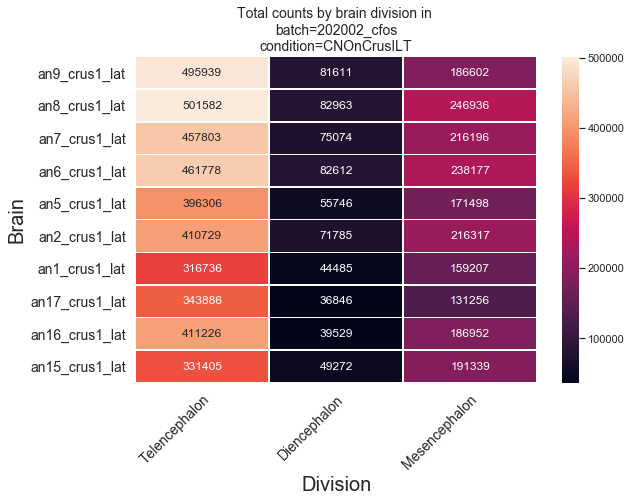

In [78]:
# total counts by division for the 10 brains in batch='202002_cfos',condition='CNOnCrusILT'
make_seaborn_heatmap_batch_condition(batch='202002_cfos',
                                     condition='CNOnCrusILT',
                                     count_type='total',
                                     savename=None)

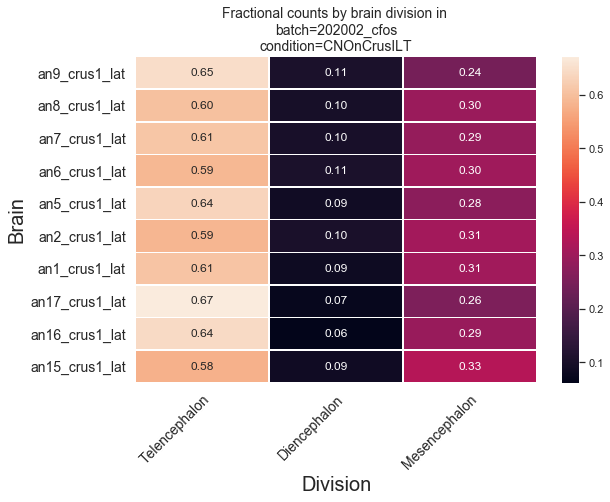

In [79]:
# fractional counts by division for the 10 brains in batch='202002_cfos',condition='CNOnCrusILT'
make_seaborn_heatmap_batch_condition(batch='202002_cfos',
                                     condition='CNOnCrusILT',
                                     count_type='frac',
                                     savename=None)

# Comparison plots between different conditions at fixed batch

## Batch = 201810_adultacutePC_ymaze_cfos

### total counts 


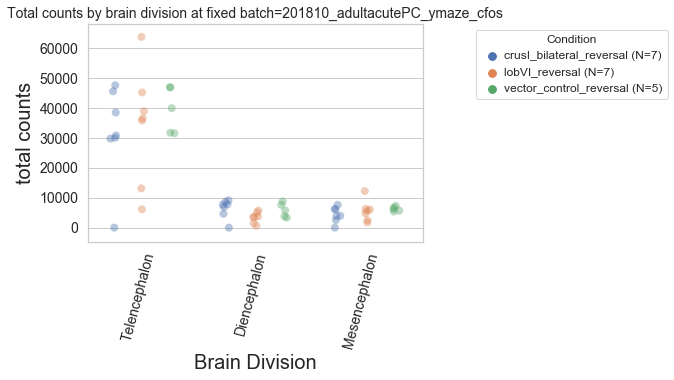

In [101]:
make_stripplot_fixed_batch(batch="201810_adultacutePC_ymaze_cfos",
                           condition_list=["crusI_bilateral_reversal",
                                           "lobVI_reversal",
                                           "vector_control_reversal"],
                           count_type='total')

### fractional counts

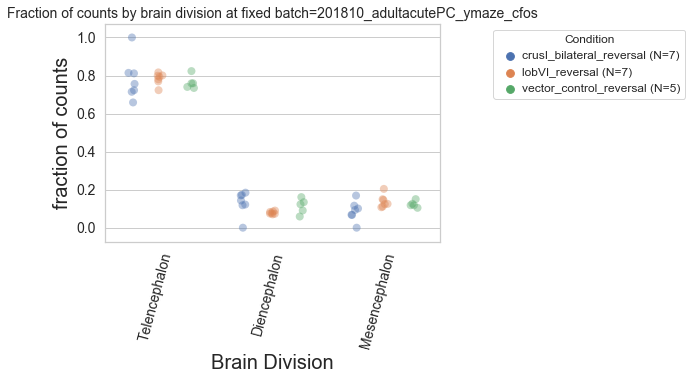

In [102]:
make_stripplot_fixed_batch(batch="201810_adultacutePC_ymaze_cfos",
                           condition_list=["crusI_bilateral_reversal",
                                           "lobVI_reversal",
                                           "vector_control_reversal"],
                           count_type='frac')

## Batch = 201904_ymaze_cfoss

### total counts

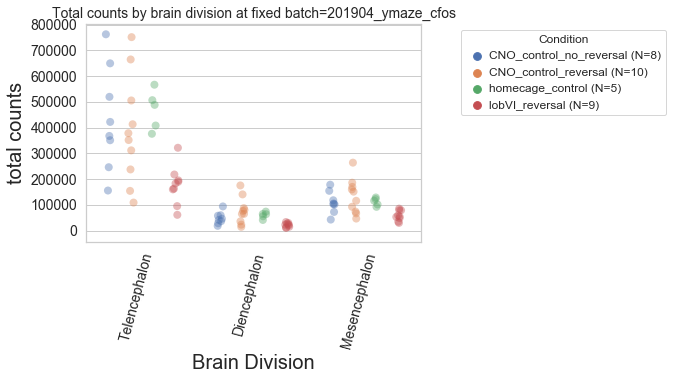

In [103]:
make_stripplot_fixed_batch(batch="201904_ymaze_cfos",
                           condition_list=["CNO_control_no_reversal",
                                           "CNO_control_reversal",
                                           "homecage_control",
                                           "lobVI_reversal"],
                           count_type='total')

### fractional counts

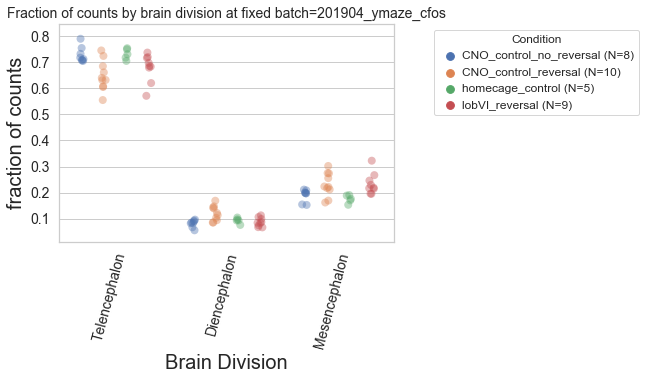

In [104]:
make_stripplot_fixed_batch(batch="201904_ymaze_cfos",
                           condition_list=["CNO_control_no_reversal",
                                           "CNO_control_reversal",
                                           "homecage_control",
                                           "lobVI_reversal"],
                           count_type='frac')

## Batch = 201908_tpham_ymaze_cfos

### total counts

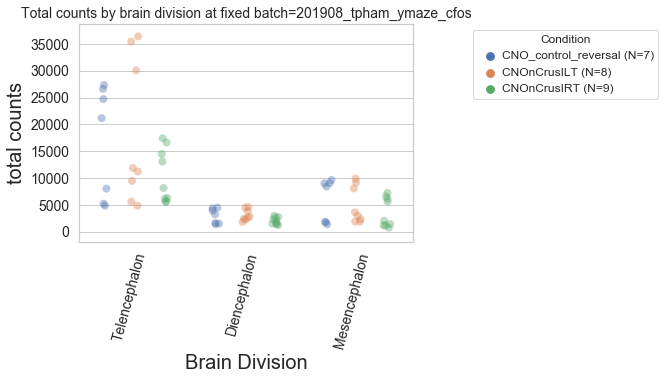

In [105]:
make_stripplot_fixed_batch(batch="201908_tpham_ymaze_cfos",
                           condition_list=["CNO_control_reversal",
                                           "CNOnCrusILT",
                                           "CNOnCrusIRT"],
                           count_type='total')

### fractional counts

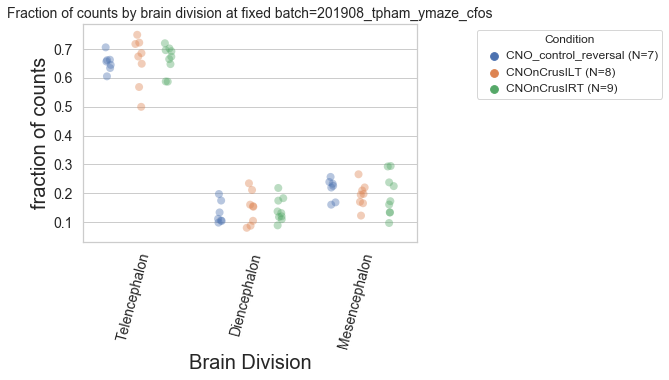

In [106]:
make_stripplot_fixed_batch(batch="201908_tpham_ymaze_cfos",
                           condition_list=["CNO_control_reversal",
                                           "CNOnCrusILT",
                                           "CNOnCrusIRT"],
                           count_type='frac')

## Batch = 202002_cfos

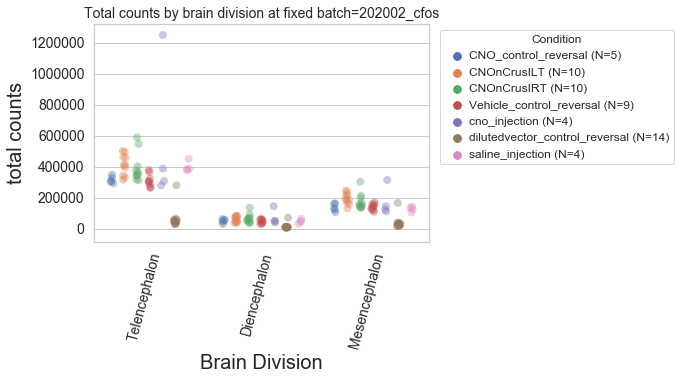

In [107]:
make_stripplot_fixed_batch(batch="202002_cfos",
                           condition_list=["CNO_control_reversal",
                                           "CNOnCrusILT",
                                           "CNOnCrusIRT",
                                           "Vehicle_control_reversal",
                                           "cno_injection",
                                           "dilutedvector_control_reversal",
                                           "saline_injection"],
                           count_type='total')

### fractional counts

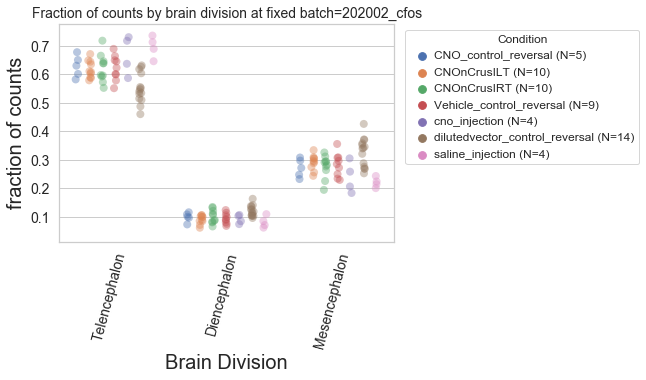

In [108]:
make_stripplot_fixed_batch(batch="202002_cfos",
                           condition_list=["CNO_control_reversal",
                                           "CNOnCrusILT",
                                           "CNOnCrusIRT",
                                           "Vehicle_control_reversal",
                                           "cno_injection",
                                           "dilutedvector_control_reversal",
                                           "saline_injection"],
                           count_type='frac')

## Batch = 202010_cfos

## total counts

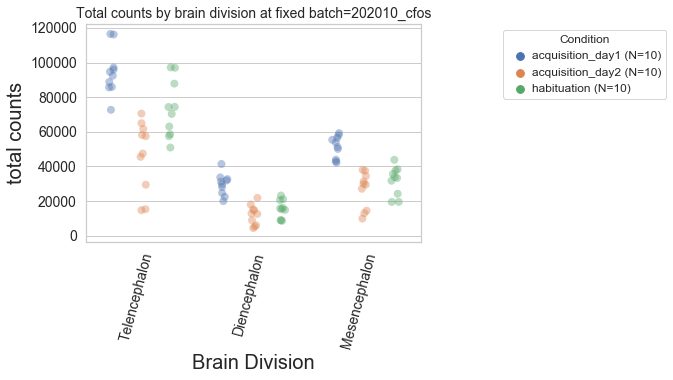

In [109]:
make_stripplot_fixed_batch(batch="202010_cfos",
                           condition_list=["acquisition_day1",
                                           "acquisition_day2",
                                           "habituation"],
                           count_type='total')

### fractional counts

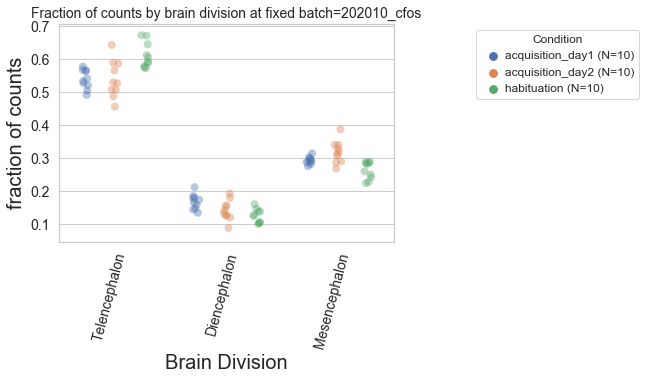

In [110]:
make_stripplot_fixed_batch(batch="202010_cfos",
                           condition_list=["acquisition_day1",
                                           "acquisition_day2",
                                           "habituation"],
                           count_type='frac')

# Comparison plots between different batches at fixed condition

# Condition = CNO_control_reversal

### total counts

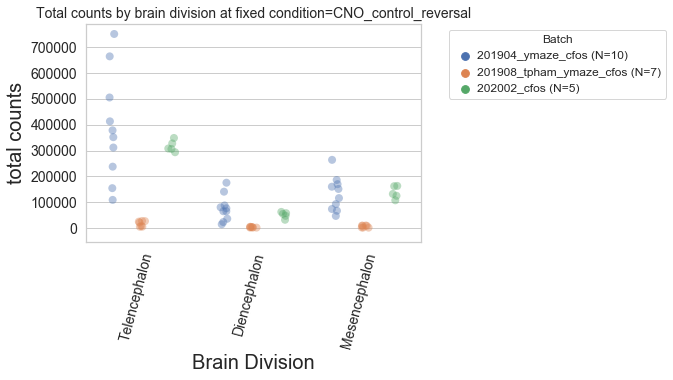

In [111]:
make_stripplot_fixed_condition(batch_list=["201904_ymaze_cfos","201908_tpham_ymaze_cfos","202002_cfos"],
                               condition="CNO_control_reversal",
                               count_type='total')

### fractional counts

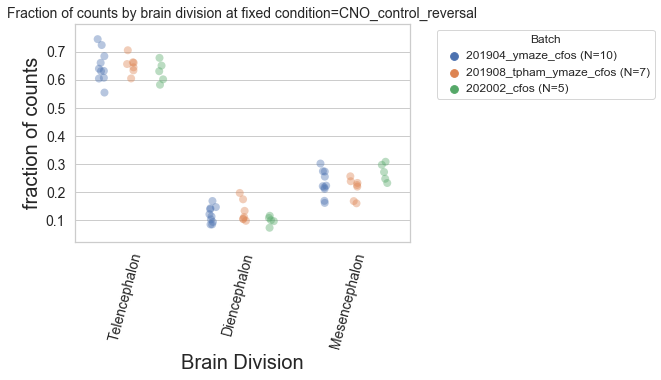

In [112]:
make_stripplot_fixed_condition(batch_list=["201904_ymaze_cfos","201908_tpham_ymaze_cfos","202002_cfos"],
                               condition="CNO_control_reversal",
                               count_type='frac')

# Condition = CNOnCrusILT

### total counts

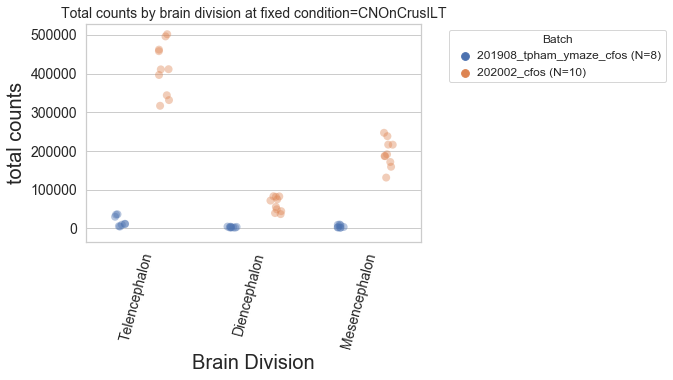

In [113]:
make_stripplot_fixed_condition(batch_list=["201908_tpham_ymaze_cfos","202002_cfos"],
                               condition="CNOnCrusILT",
                               count_type='total')

### fractional counts

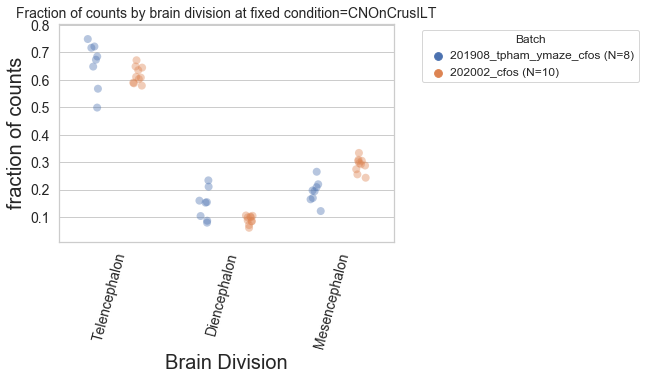

In [114]:
make_stripplot_fixed_condition(batch_list=["201908_tpham_ymaze_cfos","202002_cfos"],
                               condition="CNOnCrusILT",
                               count_type='frac')

## Condition = CNOnCrusIRT

### total counts

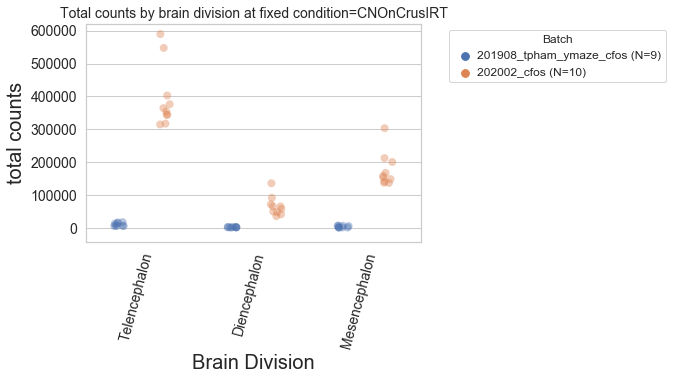

In [115]:
make_stripplot_fixed_condition(batch_list=["201908_tpham_ymaze_cfos","202002_cfos"],
                               condition="CNOnCrusIRT",
                               count_type='total')

### fractional counts

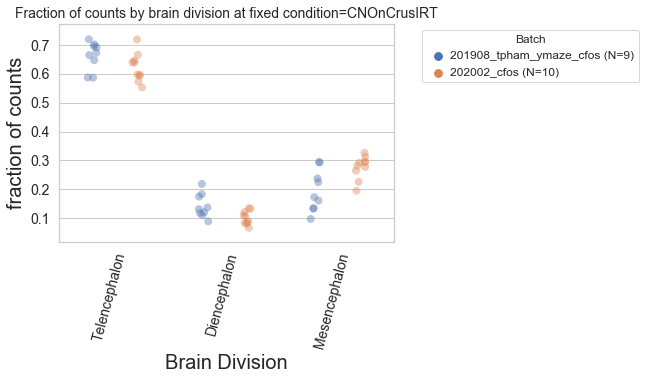

In [116]:
make_stripplot_fixed_condition(batch_list=["201908_tpham_ymaze_cfos","202002_cfos"],
                               condition="CNOnCrusIRT",
                               count_type='frac')

## Condition = lobVI_reversal

### total counts

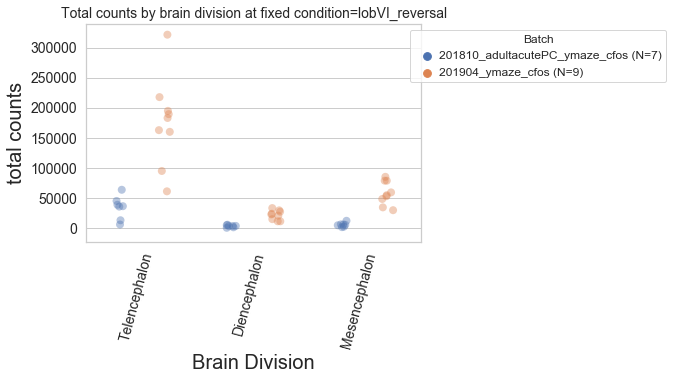

In [117]:
make_stripplot_fixed_condition(batch_list=["201810_adultacutePC_ymaze_cfos","201904_ymaze_cfos"],
                               condition="lobVI_reversal",
                               count_type='total')

### fractional counts

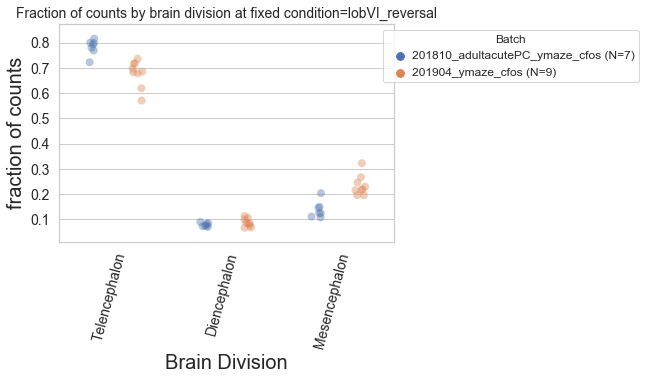

In [118]:
make_stripplot_fixed_condition(batch_list=["201810_adultacutePC_ymaze_cfos","201904_ymaze_cfos"],
                               condition="lobVI_reversal",
                               count_type='frac')